In [8]:
# Data Manipulation
import numpy as np
import pandas as pd

# Viewing images
from ipywidgets import interact
import matplotlib.pyplot as plt

# Classification
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Scene ID
from matplotlib.patches import Rectangle
from PIL import Image, ImageOps, ImageFilter

# Importing and Formatting Data

In [9]:
# Image data stored in the data column. 
# Stored as a list of 6400*3 ints. First 6400 are red, next are green, the blue. 
# Images are 80x80px
data_json = pd.read_json('shipsnet.json')
data_json.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [10]:
rgbs = data_json['data']
rgbs.head()

0    [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...
1    [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...
2    [125, 127, 129, 130, 126, 125, 129, 133, 132, ...
3    [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...
4    [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...
Name: data, dtype: object

In [11]:
rgbs = np.stack(rgbs) # Make 2d np array
r = rgbs[:,:6400]
g = rgbs[:,6400:6400*2]
b = rgbs[:,6400*2:]
r.shape, g.shape, b.shape

((4000, 6400), (4000, 6400), (4000, 6400))

$$Black\ and\ white = \frac{r + g + b}{3}$$

In [12]:
black_white = (r+g+b)/3
# black_white = black_white.reshape([4000, 80, 80])
black_white.shape

(4000, 6400)

In [13]:
# Split data
test_vectors, train_vectors, test_labels, train_labels = train_test_split(black_white, data_json['labels'],test_size=0.8, train_size=0.2)


# Viewing Images

In [14]:
def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(black_white.reshape([4000, 80, 80]), data_json['labels'], ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=1999, description='i', max=3999), Output()), _dom_classes=('widget-interact',))

# Applying SVC Model

In [15]:
def train_SVC(tmp_vectors, tmp_labels, grid_search):

    # Best parameters found{'C': 1000.0, 'kernel': 'linear', 'gamma': 0.0001}
    start = time.time()

    print("Fitting the classifier to the training set")

    if grid_search:
        # a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                      'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                      'kernel': ['linear']}
        # make a classifier by searching over a classifier and the parameter grid
        clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
    else: 
        clf = SVC(C=1000)

    # we have a "good" classifier (according to GridSearchCV), how's it look
    clf = clf.fit(tmp_vectors, tmp_labels)

    if grid_search:
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
        print("Best parameters found by grid search:")
        print(clf.best_params_)

    end = time.time()
    print("Runtime",end - start)

    pickle.dump(clf, open('best_classifier.p', 'wb'))
    return clf
    
# clf = train_SVC(train_vectors, train_labels, False)

In [16]:
svc_clf = pickle.load(open('Classifiers/SVC_classifier.p', 'rb'))

In [17]:
predictions = svc_clf.predict(test_vectors)

In [18]:
sum(predictions == test_labels)/len(test_labels) # First run was 86% accurate.

0.9725

In [19]:
print(classification_report(test_labels, predictions))
print(confusion_matrix(test_labels, predictions, labels=range(2)))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       593
          1       0.93      0.97      0.95       207

avg / total       0.97      0.97      0.97       800

[[578  15]
 [  7 200]]


In [20]:
def browse_predictions(images, labels, predictions, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Label: ' + ('%s' % categories[labels[i]]) + '\n' + 'Prediction: ' +  categories[predictions[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_predictions(test_vectors.reshape(800,80,80), np.asarray(test_labels), predictions, ['Not Boat', 'Boat'])


interactive(children=(IntSlider(value=399, description='i', max=799), Output()), _dom_classes=('widget-interact',))

# PCA

In [21]:
from sklearn.decomposition import PCA

n_components = 60 

pca = PCA(n_components=n_components, whiten=True)

_ = pca.fit(train_vectors)
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [22]:
pca_test_vectors.shape

(800, 60)

In [23]:
# clf = train_SVC(True, pca_train_vectors, train_labels, False)
pca_clf = pickle.load(open('Classifiers/PCA_classifier.p', 'rb'))

In [24]:
pca_predictions = pca_clf.predict(pca_test_vectors)
sum(pca_predictions == test_labels)/len(test_labels) # Calc Accuracy

0.8575

In [25]:
sum(pca.explained_variance_ratio_)

0.86556323110678091

# Scene Identification

In [32]:
def section_scene(scene_name):
    scene1 = Image.open("./scenes/" + scene_name) # open colour image
    scene1_bw = np.asarray(scene1)
    r, g, b = scene1_bw[:,:,0], scene1_bw[:,:,1], scene1_bw[:,:,2]

    # Change the image to grayscale to match our training set
    # scene1 = scene1.filter(ImageFilter.BoxBlur(10)) # Add blur?
    
    # Grayscale method 1
#     scene1_bw = (r+g+b)/3 # No correct classifications
    
    # Grayscale method 2
    scene1_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b # One correct classification
    
    # Grayscale method 3
#     scene1_bw = np.asarray(ImageOps.grayscale(scene1)) # One correct classification, slightly more accurate.

    # Create sections of the image to be classified
    scene1_dim = scene1_bw.shape
    scene1_sections = []
    scene1_sections_locations = []
    for i in range(scene1_dim[0] // 80): # for each row
        for j in range(scene1_dim[1] // 80): # for each column

            for x_jitter in range(0,61,20):
                xy = (i*80+x_jitter, j*80) # Jitter x direction only
                if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                    scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                    scene1_sections_locations.append(xy)
                for y_jitter in range(0,61,20):
                    xy = (i*80+x_jitter, j*80+y_jitter) # Jitter both x and y
                    if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                        scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                        scene1_sections_locations.append(xy)
                    xy = (i*80, j*80+y_jitter) # Jitter y direction only
                    if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                        scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                        scene1_sections_locations.append(xy)

    # Predict
#     scene1_predictions = svc_clf.predict(scene1_sections) # Standard
#     scene1_predictions = classifier.predict(pca.transform(scene1_sections))# PCA
    return scene1_sections, scene1_sections_locations, scene1_bw

def mark_predictions(scene_sections, scene_sections_locations, scene_predictions, scene_array):
    # Plot Marked Up Image
    fig, ax = plt.subplots(figsize=(15,18))
    ax.imshow(scene_array, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')
    for index in range(len(scene_predictions)):
        xy = scene_sections_locations[index]
        if scene_predictions[index] == 1:
            ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='red',lw=2, fill=False))
        else:
#             ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='blue',lw=0.05, fill=False))
            pass
    plt.show()

## SVC

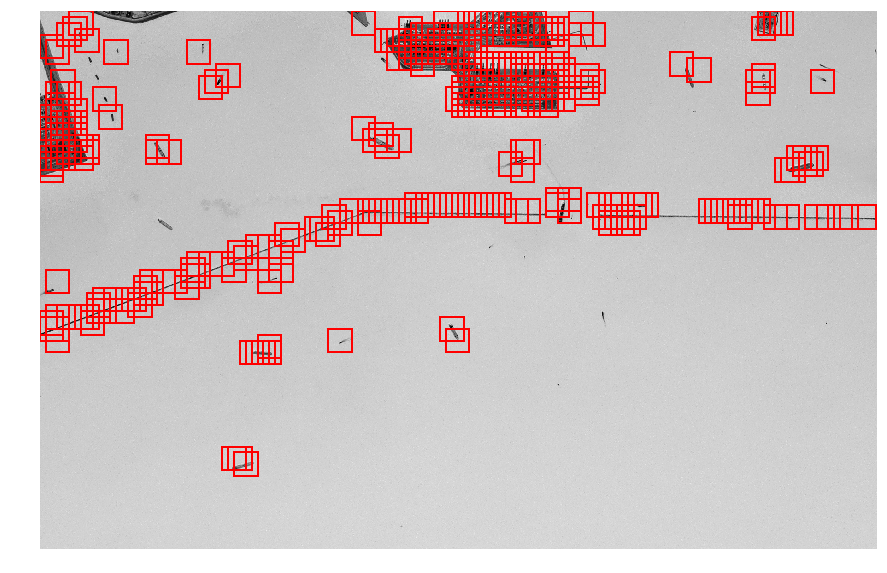

In [39]:
svc_scene_sections, svc_scene_locations, svc_scene_bw = section_scene('lb_2.png')
svc_scene_predictions = svc_clf.predict(svc_scene_sections)
mark_predictions(svc_scene_sections, svc_scene_locations, svc_scene_predictions, svc_scene_bw)

## PCA

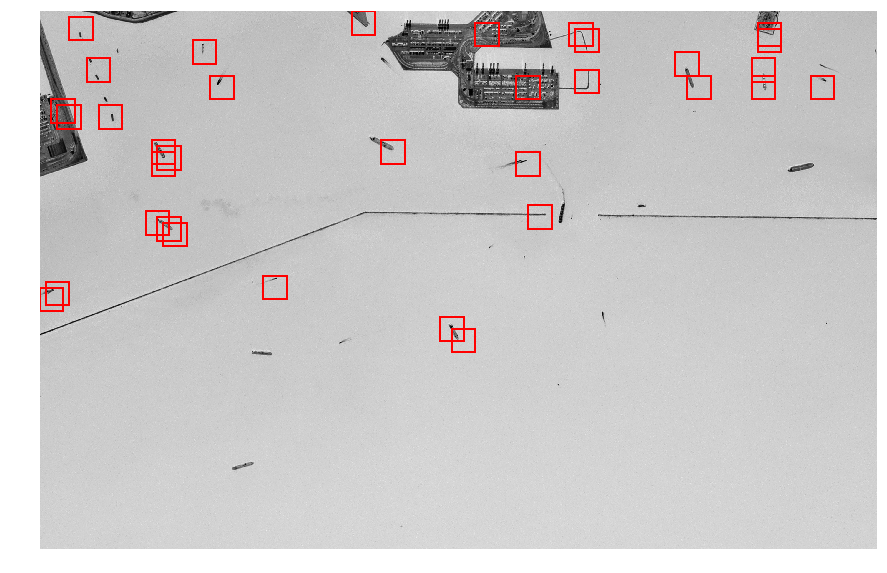

In [102]:
# svc_scene_predictions = svc_clf.predict(pca.transform(scene1_sections))
# scene1_sections, scene1_predictions = scene_identification('sfbay_1.png', pca_clf)

pca_scene_sections, pca_scene_locations, pca_scene_bw = section_scene('lb_2.png')
pca_scene_predictions = pca_clf.predict(svc_scene_sections)
mark_predictions(svc_scene_sections, svc_scene_locations, svc_scene_predictions, svc_scene_bw)

In [90]:
browse_images(np.array(scene1_sections).reshape([np.asarray(scene1_sections).shape[0],80,80]), scene1_predictions, ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=13771, description='i', max=27543), Output()), _dom_classes=('widget-interact',))

# Applying CNN Model

In [39]:
from sklearn.neural_network import MLPClassifier
TRAIN = True
if TRAIN:
    cnn_clf = MLPClassifier(solver='sgd', alpha=1e-4, hidden_layer_sizes=(1000,750,500), max_iter=2000, random_state=1)
    cnn_clf = cnn_clf.fit(train_vectors, train_labels)
    pickle.dump(cnn_clf, open('MLP_Classifier.p', 'wb'))
else:
    cnn_clf = pickle.load(open('Classifiers/MLP_classifier.p', 'rb'))
    

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/_stochastic_optimizers.py:174: RuntimeWarning: invalid value encountered in subtract
  for velocity, grad in zip(self.velocities, grads)]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [40]:
cnn_predictions = cnn_clf.predict(test_vectors)
sum(cnn_predictions == test_labels)/len(test_labels)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/label.py:614: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


0.74125

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/label.py:614: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


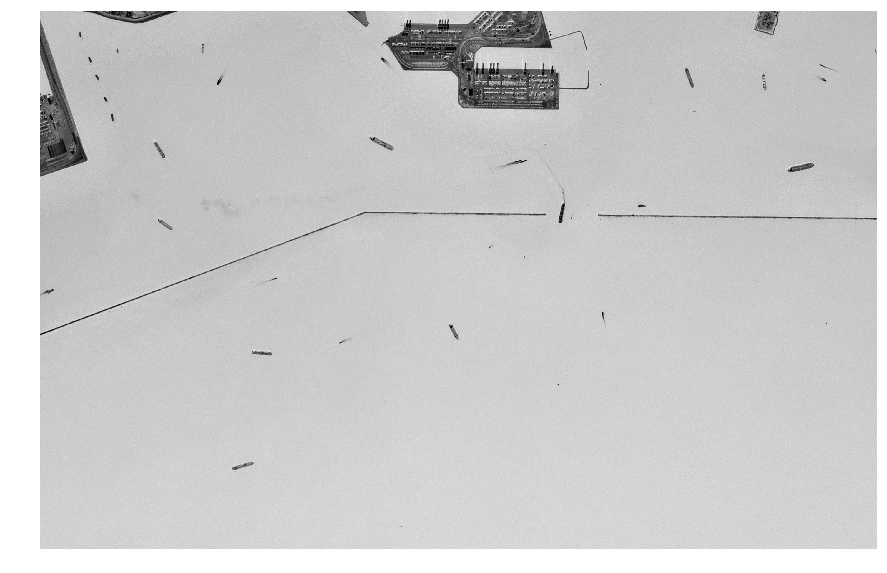

In [41]:
cnn_scene_sections, cnn_scene_locations, cnn_scene_bw = section_scene('lb_2.png')
cnn_scene_predictions = cnn_clf.predict(cnn_scene_sections)
mark_predictions(cnn_scene_sections, cnn_scene_locations, cnn_scene_predictions, cnn_scene_bw)

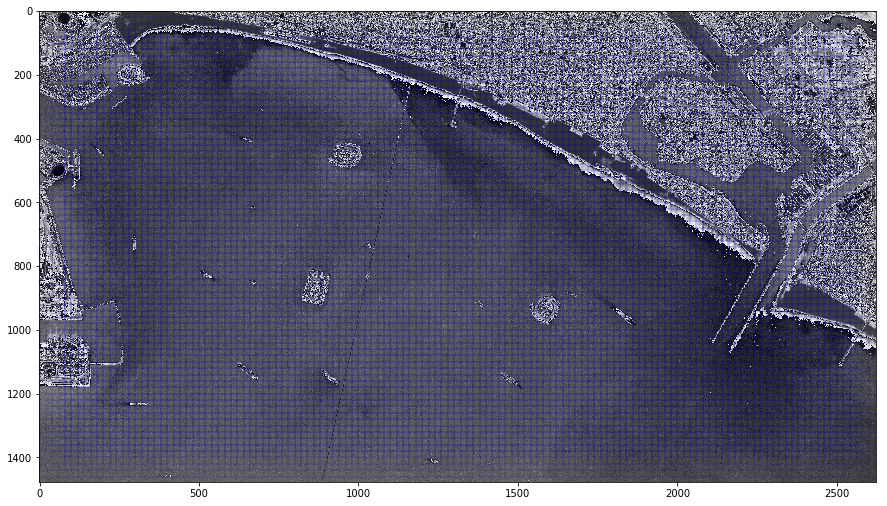

In [30]:
from PIL import Image, ImageOps, ImageFilter
scene1 = Image.open("./scenes/lb_4.png") # open colour image

# scene1 = scene1.filter(ImageFilter.BoxBlur(10))
scene1_bw = np.asarray(scene1)
r, g, b = scene1_bw[:,:,0], scene1_bw[:,:,1], scene1_bw[:,:,2]
scene1_bw = (r+g+b)/3 # No correct classifications
# scene1_bw[scene1_bw > 255] = 255
# scene1_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b # One correct classification
# scene1_bw = np.asarray(ImageOps.grayscale(scene1)) # One correct classification, slightly more accurate.


# Plot Unmarked Black White Image
# plt.figure(figsize=(15,18))
# plt.imshow(scene1_bw, cmap=plt.cm.gray_r, interpolation='nearest')
# plt.axis('off')
# plt.show()

# Create sections of the image to be classified
scene1_dim = scene1_bw.shape
scene1_sections = []
scene1_sections_locations = []
for i in range(scene1_dim[0] // 80): # for each row
    for j in range(scene1_dim[1] // 80): # for each column
#         xy = (i*80, j*80)  # xy coords of the top left point of a sqare
        
        for x_jitter in range(0,80,20):
            for y_jitter in range(0,80,20):
                xy = (i*80+x_jitter, j*80+y_jitter)
                if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                    scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                    scene1_sections_locations.append(xy)
# np.array(scene1_sections).shape

# Predict
scene1_predictions = cnn_clf.predict(scene1_sections) # Standard
# scene1_predictions = clf.predict(pca.transform(scene1_sections))# PCA

# Plot Marked Up Image
fig, ax = plt.subplots(figsize=(15,18))
ax.imshow(scene1_bw, cmap=plt.cm.gray_r, interpolation='nearest')
# ax.axis('off')
for index in range(len(scene1_predictions)):
    xy = scene1_sections_locations[index]
    if scene1_predictions[index] == 1:
        ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='red',lw=2, fill=False))
    else:
#         ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='blue',lw=0.05, fill=False))
    pass
plt.show()